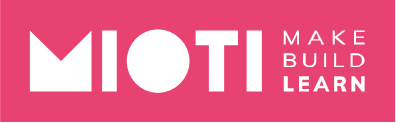
<br/>
<center style="color:#888">Master Deep Learning<br/>Asignatura Computer Vision</center>
<center style="color:#aaa; margin-top:10px;">Prof. Óscar Picazo Montoya<br>oscarpm@faculty.mioti.es</center>


# Challenge S5: Buscando al asesino

## Objetivos

<pre>
05:13 (AM): Un sonido de cristal roto interrumpe el silencio en las oficinas del Banco de España. Alguien ha irrumpido en la cámara acorazada y en el camino ha dejado un par de vigilantes muertos. Suena la alarma.

06:17 (AM): Se persona la Guardia Civil en la cámara, han desaparecido todas las reservas de Oro. Sólo se ha encontrado un móvil en la escena del crimen con 2 fotografías en el carrete. Los agentes revisan las fotografías y no ven más que un par de imágenes de un escritorio...
</pre>

Como estudiantes de visión por computador... ¿podemos ayudar a resolver el misterio? ¿podemos descubrir quien es el asesino?

## Configuración del entorno

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import data, io, filters, color
from skimage.color import rgb2gray
from skimage.feature import ORB, match_descriptors, plot_matches
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform, AffineTransform, EuclideanTransform, FundamentalMatrixTransform
from skimage.transform import resize
from skimage.transform import warp

from ipywidgets import interactive, IntSlider, FloatSlider, VBox, HBox
from IPython.core.display import display, HTML

import operator
import math
import warnings
warnings.filterwarnings("ignore")

from utils import dibujar_corners, dibujar_img, dibujar_imgs, dibujar_puntos, mostrar_frames
from utils import blend_rgb
from utils import extraer_ventana, iterador_ventanas,pega_imagenes

## Las pruebas del delito

Dispones en la carpeta `imgs` las fotos del delito:

In [2]:
dataset_rgb = io.ImageCollection('imgs/*.jpg')
print("Cargadas {} instancias.".format(len(dataset_rgb)))

Cargadas 2 instancias.


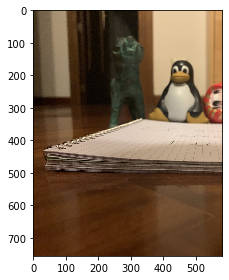

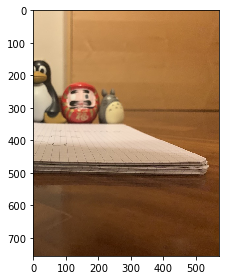

In [3]:
mostrar_frames(dataset_rgb)

## Pegado de las imágenes

¿Crees que con lo que hemos aprendido de pegado de imágenes podemos generar una única imagen con las que tenemos?

* ***Respuesta:*** Procedemos a utilizar la imagen pega_imagenes que hemos visto en el worksheet. En esta función se recogian todos los pasos vistos para poder pegar las dos partes de una fotografía. En esta función se acometían los siguientes pasos para llegar a un pegado homegeneo:
    * 1- Extraemos los match o puntos de interes de las dos imagenes.
    * 2- Posteriormente aplica ransac para sacra las transformaciones y los inliers. Es decir los puntos que tienen realmente relación o que se ajustan mejor. 
    * 3- Una vez que tenemos el modelo de las transformaciones, aplicamos la función warp a ambas imagenes, a una con una AffineTrasnform o transformación afine que no realiza ningún cambio y a la otra imagen se le hace la proyección con la trasformación calcula en ransac.
    * 4- Una vez realizado esto se llama a la función blended_imagen que nos mezcla las dos imagenes.

In [4]:
imagen_fusionada=pega_imagenes(dataset_rgb[0],dataset_rgb[1]) # pega_imagenes la hemos pasado a utils.py

Extraidos 600 keypoints de img_a...
Extraidos 600 keypoints de img_b...
Localizados 162 matches...
Ransac completado con 49 inliers...


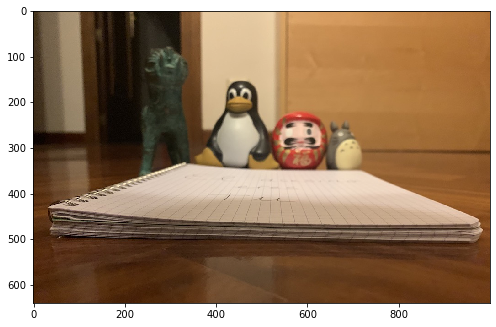

In [5]:
dibujar_img(imagen_fusionada)

## Ortorrectificación

Una vez que tengas una sola imagen, ¿se te ocurre alguna manera para poder leer lo que pone en la imagen?

* ***Respuesta :*** Procedemos a cambiar la perspectiva, identificando cuatro puntos del cuaderno, correspondiente principalmente a las 4 esquinas. También identificaremos los 4 puntos donde los queremos llevar para que queden perfectamente alineados. Para ello usaremos la transformación proyectiva, ProjectveTransform y posteriomente le aplicaremos una proyección afín, AffineTransform, para centrarla.Con esto conseguiremos que el cuaderno, se "ponga de pie" o mejor dicho nosotros como observadores nos posicionemos encima de la hoja del cuaderno, que tiene escrito el nombre del asesino.

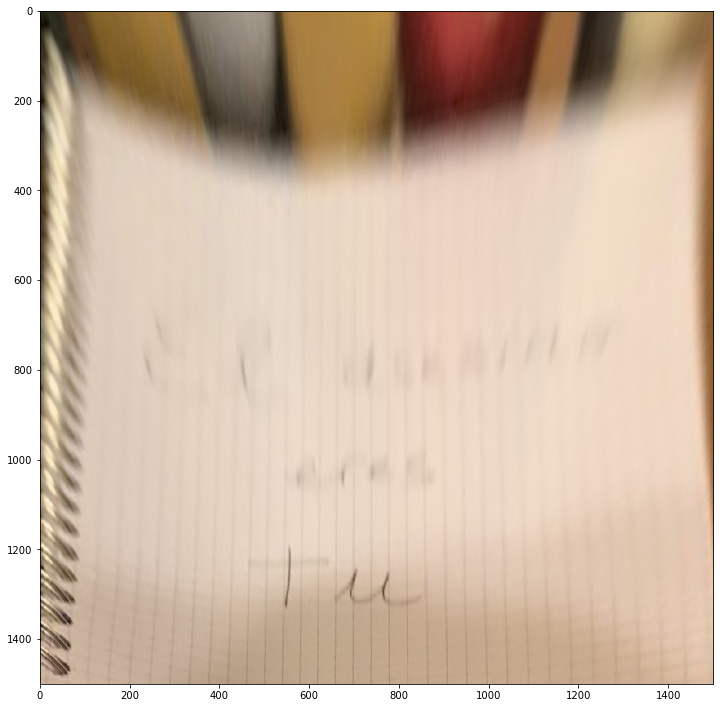

In [6]:
esquinas = np.array([[40, 430], [965, 455], [715, 345], [330, 330]])
esquinas_orto = np.array([[0, 1500], [1500, 1500], [1500, 0], [0, 0]])# Puntos donde queremos que vaya.

proj = ProjectiveTransform()
proj.estimate(esquinas, esquinas_orto)

img_stitch_orto = warp(imagen_fusionada, proj.inverse, output_shape=(1500, 1500))
dibujar_img(img_stitch_orto, size=(10,10))

## Mejora de imagen

¿Se te ocurre aplicar algún tipo de técnica que conozcamos para mejorar la imagen pegada?. Piensa que un juez tendrá que ver muy claras las pruebas.

* ***Respuesta:*** Aplicamos uno de los filtros del tema 1. En concreto una ecualización adaptativa para repartir un poco más la distribución de los colores y así clarificar un poco más el texto que se encuentra en el cuaderno. Las primeras palabras al faltar información visual, se pueden clarificar poco.

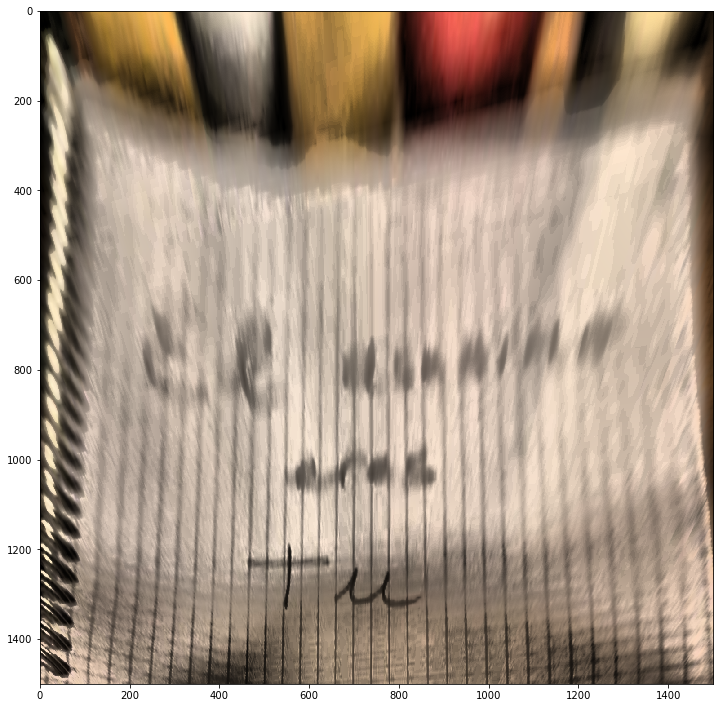

In [7]:
# Aplicamos una ecualizacion adaptativa
from skimage import exposure
img_equalized = exposure.equalize_adapthist(img_stitch_orto, clip_limit=0.045)
dibujar_img(img_equalized, size=(10,10))


## ¿Quién es el asesino?

* ***Respuesta :*** Según el texto que se visualiza en el cuaderno **" El asesino eres tu "**